v1.0

In [1]:
import time
t_start = time.time()

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    google_env = True
except:
    print("Not a Goolge Drive Environment.")
    google_env = False

Not a Goolge Drive Environment.


In [3]:
# Use parameters to enable/disable the fastrun

FASTRUN = False
#FASTRUN = True

# Size of the fastrun dataframe
sample_fraction = 0.1
print("==="*40)
print("Fastrun enabled:", FASTRUN)
if FASTRUN: print("Sample size:",sample_fraction)
print("==="*40)

Fastrun enabled: False


# Setup Environment

## Install Modules

In [4]:
#!pip install yellowbrick
#!pip install icecream
#!pip install watermark
#!pip install fastparquet

## Import Modules

In [5]:
# Base libraries
import os
import re
import platform

# Scientific libraries
import numpy as np
import pandas as pd

# Specific libraries
#from ftlangdetect import detect

# Machine learning libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
#import mglearn  # does not work in Google Colabs :-(
import seaborn as sns

sns.set(rc={'figure.figsize': (15, 10)})
sns.set(font_scale=0.8)

# Helper libraries
from tqdm import tqdm
tqdm.pandas()
from icecream import ic
from watermark import watermark
import gc  # garbage collection to optimize memory usage, use gc.collect()
import warnings

warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark

## Define Parameters

In [6]:
# sklearn
seed = 42

## Helper Functions

In [7]:
def feature_check(df, col):
    """Function to review features."""

    print("Feature name:", col)
    print('Data type:', df.dtypes[col])
    print('Missing values:', df[col].isna().sum())
    print('Count unique values:', df[col].nunique())
    print('Count -1 values (= missing):', len(df[df[col] == -1]))
    print()
    #print('Unique values:', sorted(list(df[col].unique())))
    print(df[col].describe())
    print()
    #print(df[col].value_counts().hist(figsize=(5,2)))
    if df[col].nunique() < 10000:
        try:
            sns.set(rc={'figure.figsize': (15, 5)})
            sns.histplot(x=col, data=df, hue='label');
            #df_temp = df[df[col] != -1]
            #sns.histplot(x=col, data=df_temp, hue='label');
        except:
            print("no distribution plot possible:")
    else:
        print("Too many unique values for a hist plot.")
    print()

In [8]:
def fast_run_sampling(df):
    print("Labels before sampling:\n", df['label'].value_counts())
    df = df.groupby('label').sample(frac=sample_fraction, random_state=seed) 
    #df = df.sample(n=sample_size, random_state=seed).reset_index(drop=True)
    print("Labels after sampling:\n", df['label'].value_counts())
    
    return df

# Load Data

In [9]:
if google_env:
    # Location for "shared with" people
    # create a shortcut of the shared folder in your Google Drive root folder
    ROOT_PATH = "/content/drive/MyDrive/SIADS696/Environment/"

    PATH_DATA = "data/"
    PATH_DATA_RAW = "data/raw/"
    PATH_DATA_INT = "data/interim/"
    PATH_DATA_PRO = "data/processed/"
    PATH_DATA_MOD = "models/"

else:
    ROOT_PATH = "../"
    print("Not a Goolge Drive Environment. Loading local files.")
    PATH_DATA = "../data/"
    PATH_DATA_RAW = "data/raw/"
    PATH_DATA_INT = "data/interim/"
    PATH_DATA_PRO = "data/interim/"
    PATH_DATA_MOD = "models/"
    
df_wiki_train_stats = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + "train_features_clean_stats.parquet.gzip")
df_wiki_test_stats = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + "test_features_clean_stats.parquet.gzip")

df_wiki_train_rs = pd.read_parquet(ROOT_PATH + PATH_DATA_INT+"train_features_rs.parquet.gzip")
df_wiki_test_rs = pd.read_parquet(ROOT_PATH + PATH_DATA_INT+"test_features_rs.parquet.gzip")

df_wiki_train_nltk = pd.read_csv(ROOT_PATH + PATH_DATA_INT+"train_features_nltk.csv")
df_wiki_test_nltk = pd.read_csv(ROOT_PATH + PATH_DATA_INT+"test_features_nltk.csv")

df_wiki_train_aoa = pd.read_csv(ROOT_PATH + PATH_DATA_INT+"train_features_aoa.csv")
df_wiki_test_aoa = pd.read_csv(ROOT_PATH + PATH_DATA_INT+"test_features_aoa.csv")

df_wiki_train_crb = pd.read_csv(ROOT_PATH + PATH_DATA_INT+"train_features_crb.csv")
df_wiki_test_crb = pd.read_csv(ROOT_PATH + PATH_DATA_INT+"test_features_crb.csv")

df_wiki_train_w2v = pd.read_csv(ROOT_PATH + PATH_DATA_INT+"train_features_w2v.csv")
df_wiki_test_w2v = pd.read_csv(ROOT_PATH + PATH_DATA_INT+"test_features_w2v.csv")

df_wiki_train_MNB = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + 'train_mNB_predict.parquet.gzip')  # data leakage risk
df_wiki_test_MNB = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + 'test_mNB_predict.parquet.gzip')    # data leakage risk

Not a Goolge Drive Environment. Loading local files.


In [10]:
# Combine the training dataframes into a single dataframe
df_train = pd.DataFrame()
df_train = pd.concat([df_train, 
                      df_wiki_train_stats,
                      df_wiki_train_rs,
                      df_wiki_train_nltk,
                      df_wiki_train_aoa,
                      df_wiki_train_crb,
                      df_wiki_train_w2v,
                      ], axis=1)

# df_train[df_train['stats_language_no'] == 18]['stats_language_code'].head(5)  # checking that 18 is English

columns_list_train = df_train.columns.to_list()
columns_list_train = sorted(list(set(columns_list_train) - {"original_text", "cleaned_text", "stats_language_code"}))

print("Features: ", len(columns_list_train))
df_train = df_train[columns_list_train].copy()

if FASTRUN:
    df_train = fast_run_sampling(df_train)

Features:  152


In [11]:
# Combine the test dataframes into a single dataframe
df_test = pd.DataFrame()
df_test = pd.concat([df_test, 
                     df_wiki_test_stats,
                     df_wiki_test_rs,
                     df_wiki_test_nltk,
                     df_wiki_test_aoa,
                     df_wiki_test_crb,
                     df_wiki_test_w2v
                     ], axis=1)

columns_list_test = df_test.columns
columns_list_test = sorted(list(set(columns_list_test) - {"original_text", "cleaned_text", "id", "stats_language_code"}))

print("Features: ", len(columns_list_test))
df_test = df_test[columns_list_test].copy()

if FASTRUN:
    df_test = fast_run_sampling(df_test)


Features:  152


# Feature Analysis

## Describe datasets

In [12]:
df_train.describe(exclude='object').round(2).T

,count,mean,std,min,25%,50%,75%,max
aoa_aoa_bird_lem_max,416768.0,6.98,2.52,-1.0,5.53,6.97,8.69,13.14
aoa_aoa_bird_lem_mean,416768.0,4.73,1.42,-1.0,4.61,4.93,5.28,12.98
aoa_aoa_bird_lem_min,416768.0,3.39,1.17,-1.0,3.16,3.63,3.92,12.98
aoa_aoa_bird_lem_sum,416768.0,43.14,27.53,-1.0,23.39,39.37,59.09,237.78
aoa_aoa_bristol_lem_max,416768.0,7.40,3.58,-1.0,6.30,8.41,9.75,13.64
aoa_aoa_bristol_lem_mean,416768.0,6.20,2.98,-1.0,5.67,6.83,7.95,13.64
aoa_aoa_bristol_lem_min,416768.0,5.11,2.75,-1.0,4.47,5.26,6.45,13.64
aoa_aoa_bristol_lem_sum,416768.0,20.45,16.64,-1.0,8.60,17.68,29.12,159.24
aoa_aoa_cort_lem_max,416768.0,6.04,2.45,-1.0,4.93,6.13,7.49,13.65
aoa_aoa_cort_lem_mean,416768.0,4.03,1.33,-1.0,3.83,4.20,4.57,13.57


In [13]:
df_test.describe(exclude='object').round(2).T

,count,mean,std,min,25%,50%,75%,max
aoa_aoa_bird_lem_max,119092.0,6.99,2.51,-1.0,5.53,6.97,8.69,13.14
aoa_aoa_bird_lem_mean,119092.0,4.74,1.41,-1.0,4.61,4.93,5.28,12.98
aoa_aoa_bird_lem_min,119092.0,3.39,1.17,-1.0,3.16,3.63,3.92,12.98
aoa_aoa_bird_lem_sum,119092.0,43.32,27.58,-1.0,23.56,39.60,59.46,206.64
aoa_aoa_bristol_lem_max,119092.0,7.42,3.57,-1.0,6.33,8.43,9.75,13.64
aoa_aoa_bristol_lem_mean,119092.0,6.21,2.97,-1.0,5.67,6.83,7.94,13.64
aoa_aoa_bristol_lem_min,119092.0,5.11,2.74,-1.0,4.47,5.26,6.45,13.64
aoa_aoa_bristol_lem_sum,119092.0,20.50,16.56,-1.0,8.60,17.82,29.16,141.23
aoa_aoa_cort_lem_max,119092.0,6.06,2.45,-1.0,4.99,6.13,7.50,13.65
aoa_aoa_cort_lem_mean,119092.0,4.03,1.32,-1.0,3.84,4.21,4.58,13.20


## Create Feature Histograms

Generate histograms of each feature in the simple/complex text classification classes

In [14]:
def plot_histograms(feature_group_train, df_train):
    # Calculate the number of rows needed for the subplots 
    plots_count = len(feature_group_train)
    # Add one more plot if feature list length is odd
    if plots_count % 2 != 0:
        plots_count =  int(plots_count / 2) + 1
    else:
        plots_count =  int(plots_count / 2)

    # Create subplots with the determined number of rows and 2 columns
    # figsize parameter sets the size of the plot
    fig, axes = plt.subplots(plots_count, 2, figsize=(15, plots_count*5))

    # Filter rows with label 0 and store it in label_0
    label_0 = df_train[df_train.label == 0]

    # Filter rows with label 1 and store it in label_1
    label_1 = df_train[df_train.label == 1]

    # Flatten the array of subplots into a 1D array
    ax = axes.ravel()

    # Iterate over each column in training dataframe
    #for i, col in enumerate(df_train.columns):
    for i, col in enumerate(feature_group_train):
        _, bins = np.histogram(df_train[col], bins=50)
        _ = ax[i].hist(label_0[col], bins=bins, alpha=.5)
        _ = ax[i].hist(label_1[col], bins=bins, alpha=.5)
        ax[i].set_title(col)
        ax[i].set_yticks(())
        
    ax[0].set_xlabel("Feature magnitude")
    ax[0].set_ylabel("Frequency")
    ax[0].legend(["0", "1"], loc="best")
    fig.tight_layout();

### Stats_

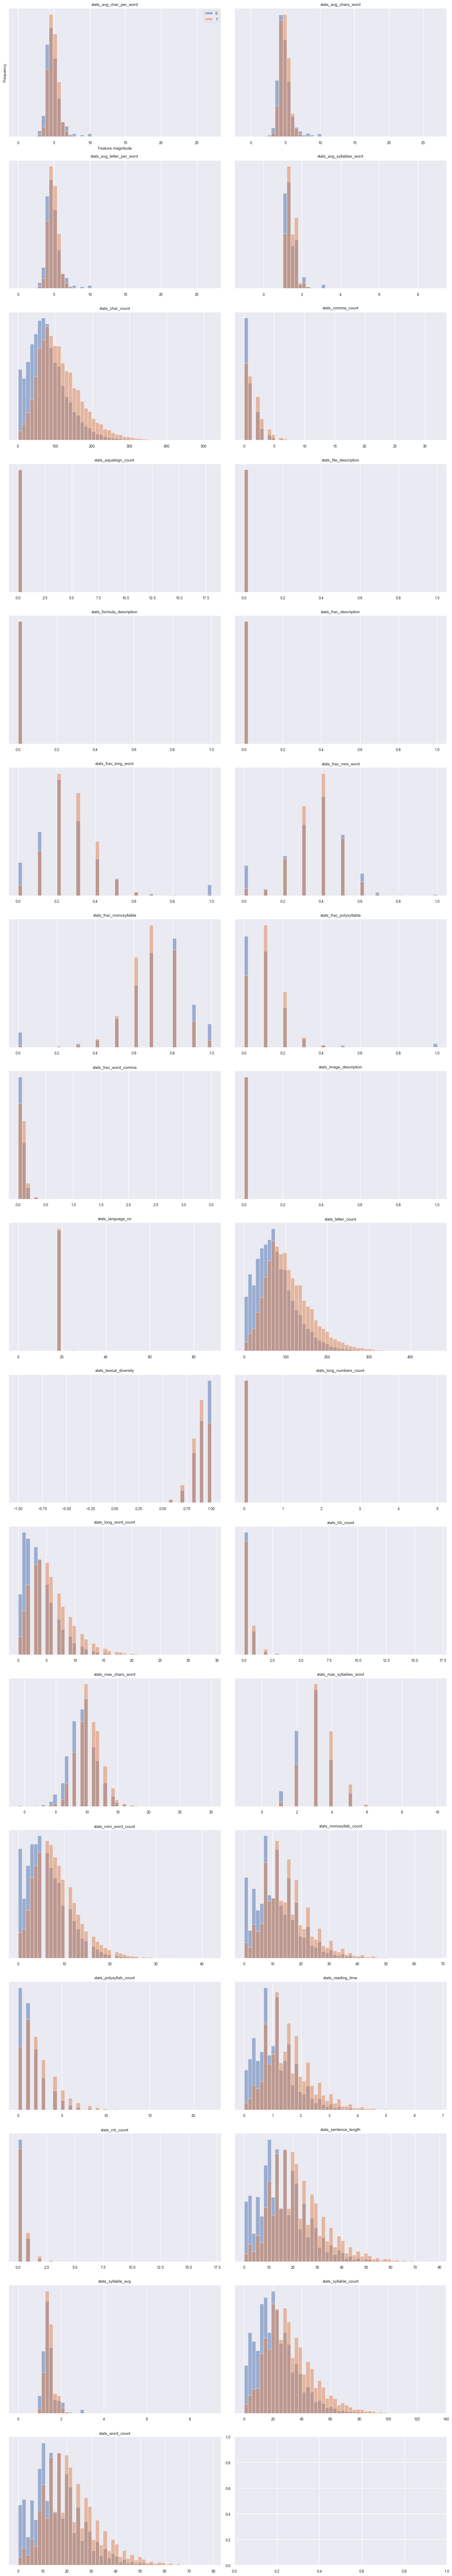

In [15]:
# Analyze rs_ feature group
feature_group = "stats_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

#ic(len(feature_group_train))
#ic(feature_group_train)

plot_histograms(feature_group_train, df_train)

### RS_

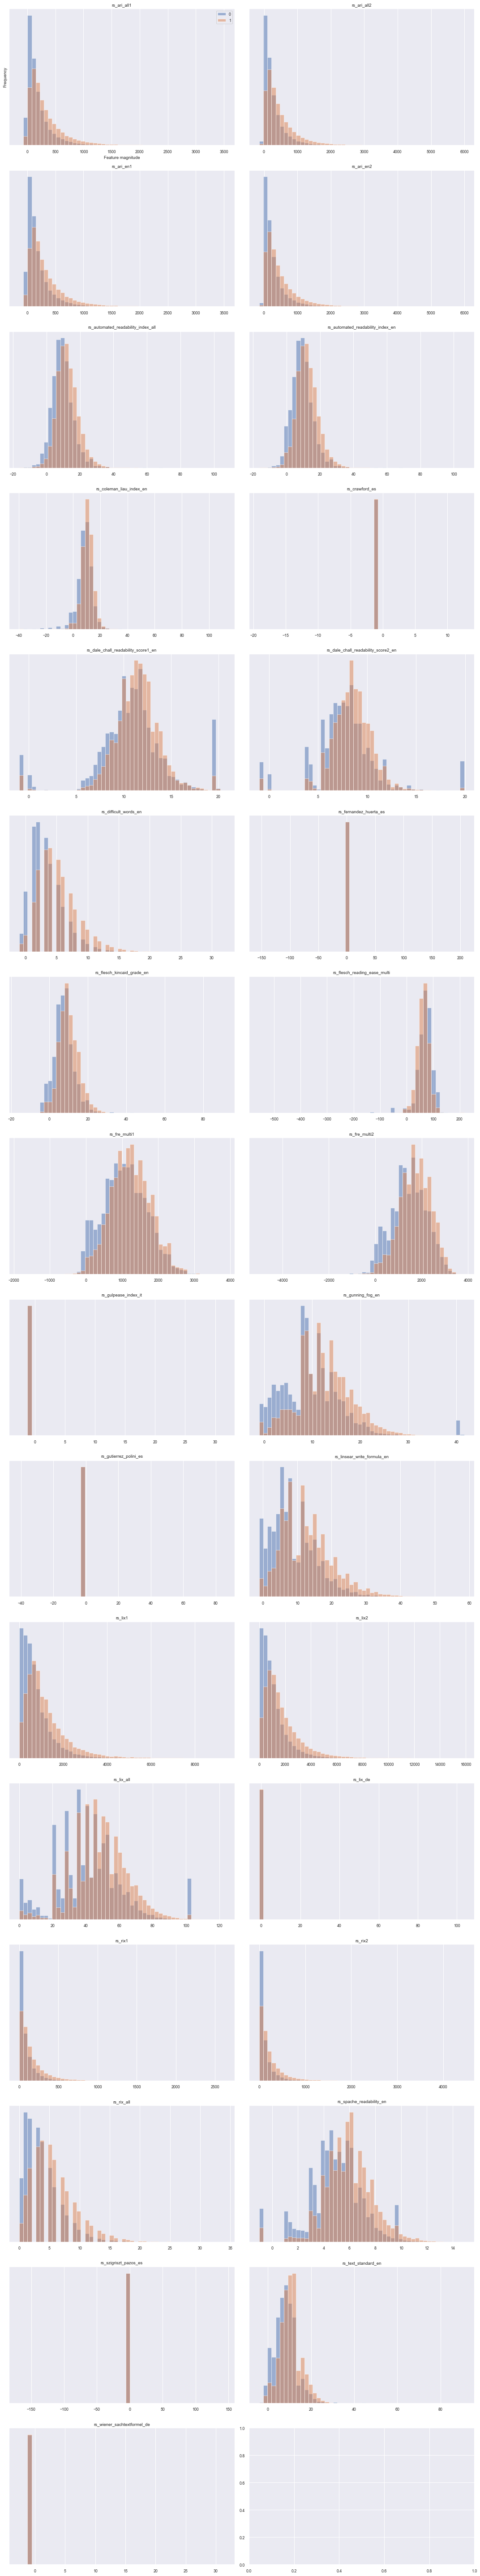

In [16]:
# Analyze rs_ feature group
feature_group = "rs_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

#ic(len(feature_group_train))
#ic(feature_group_train)

plot_histograms(feature_group_train, df_train)

### NLTK_

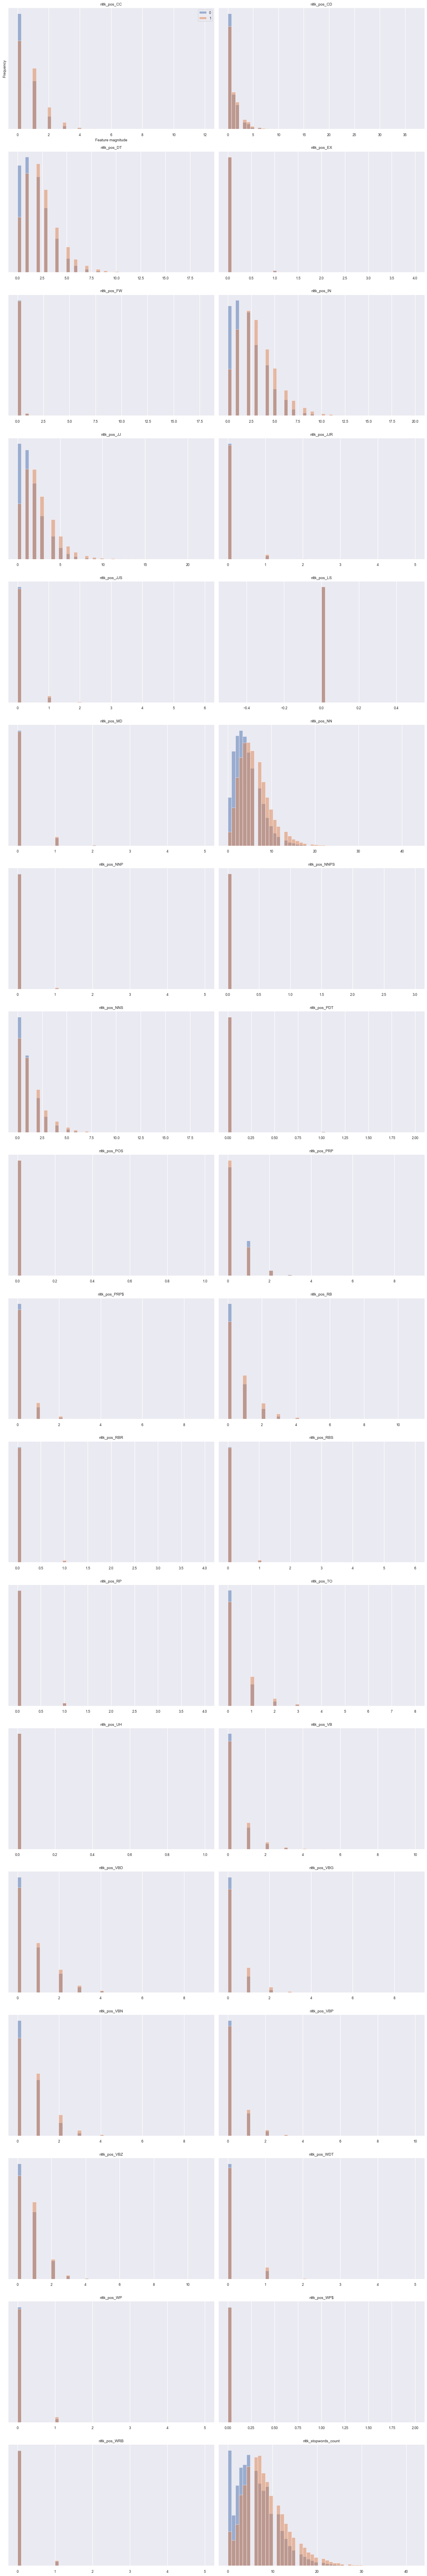

In [17]:
# Analyze rs_ feature group
feature_group = "nltk_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

#ic(len(feature_group_train))
#ic(feature_group_train)

plot_histograms(feature_group_train, df_train)

### AOA_

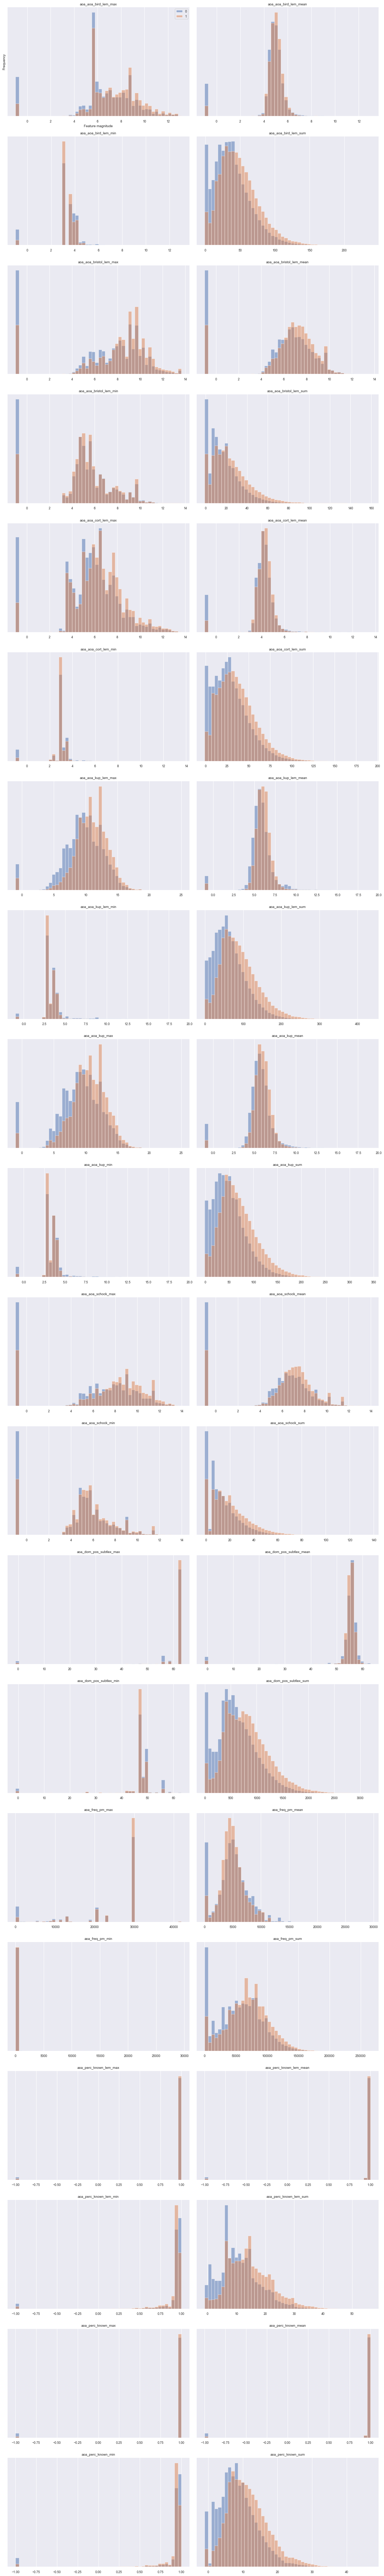

In [18]:
# Analyze rs_ feature group
feature_group = "aoa_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

#ic(len(feature_group_train))
#ic(feature_group_train)

plot_histograms(feature_group_train, df_train)

### CRB_

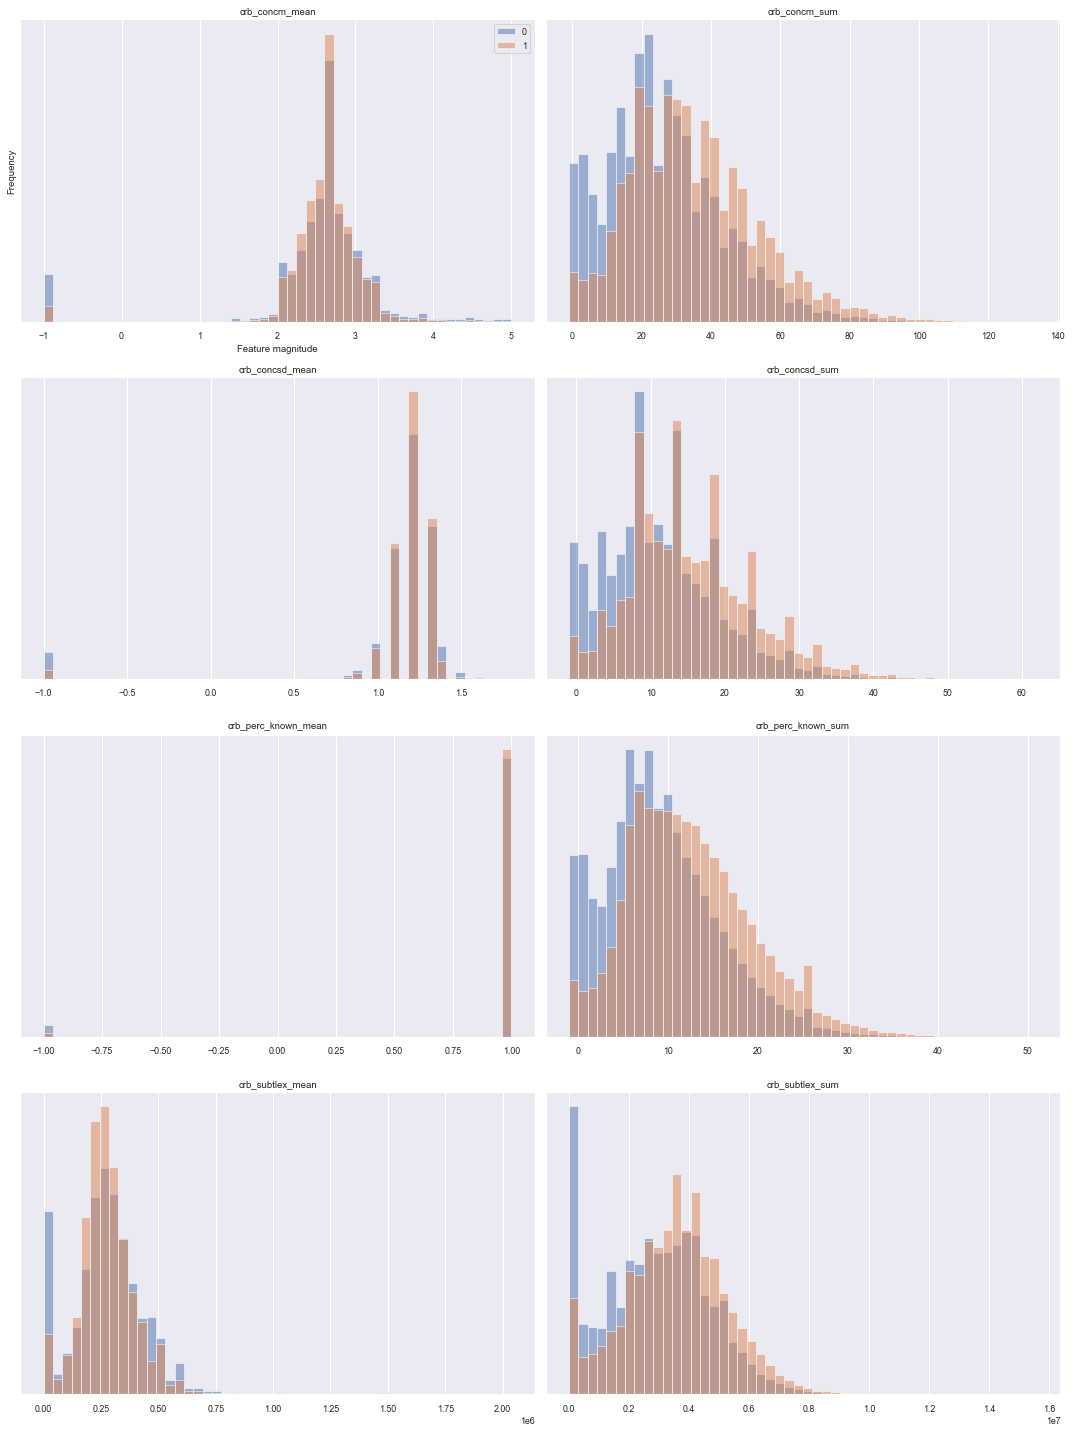

In [19]:
# Analyze rs_ feature group
feature_group = "crb_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

#ic(len(feature_group_train))
#ic(feature_group_train)

plot_histograms(feature_group_train, df_train)

### W2V_

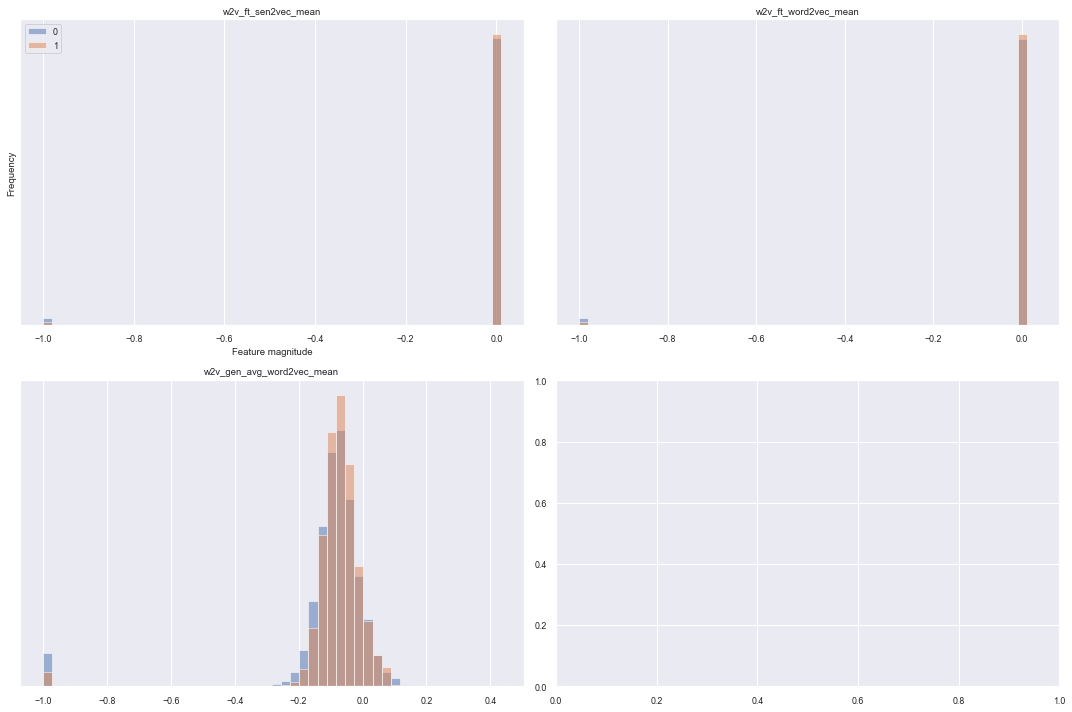

In [20]:
# Analyze rs_ feature group
feature_group = "w2v_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

#ic(len(feature_group_train))
#ic(feature_group_train)

plot_histograms(feature_group_train, df_train)

## Create Box-Plots

In [21]:
def plot_boxplots(feature_group_train, df_train):
    # Calculate the number of rows needed for the subplots 
    plots_count = len(feature_group_train)
    # Add one more plot if feature list length is odd
    if plots_count % 2 != 0:
        plots_count =  int(plots_count / 2) + 1
    else:
        plots_count =  int(plots_count / 2)

    fig, axes = plt.subplots(plots_count, 2, figsize=(15, plots_count*6))
    # Flatten the array of subplots into a 1D array
    ax = axes.ravel()

    for i, feat in enumerate(feature_group_train):
        # Plot the box plot
        sns.boxplot(x=df_train["label"], y=df_train[feat], data=df_train, ax=ax[i]);

    # Show the plot
    plt.show();

### stats_

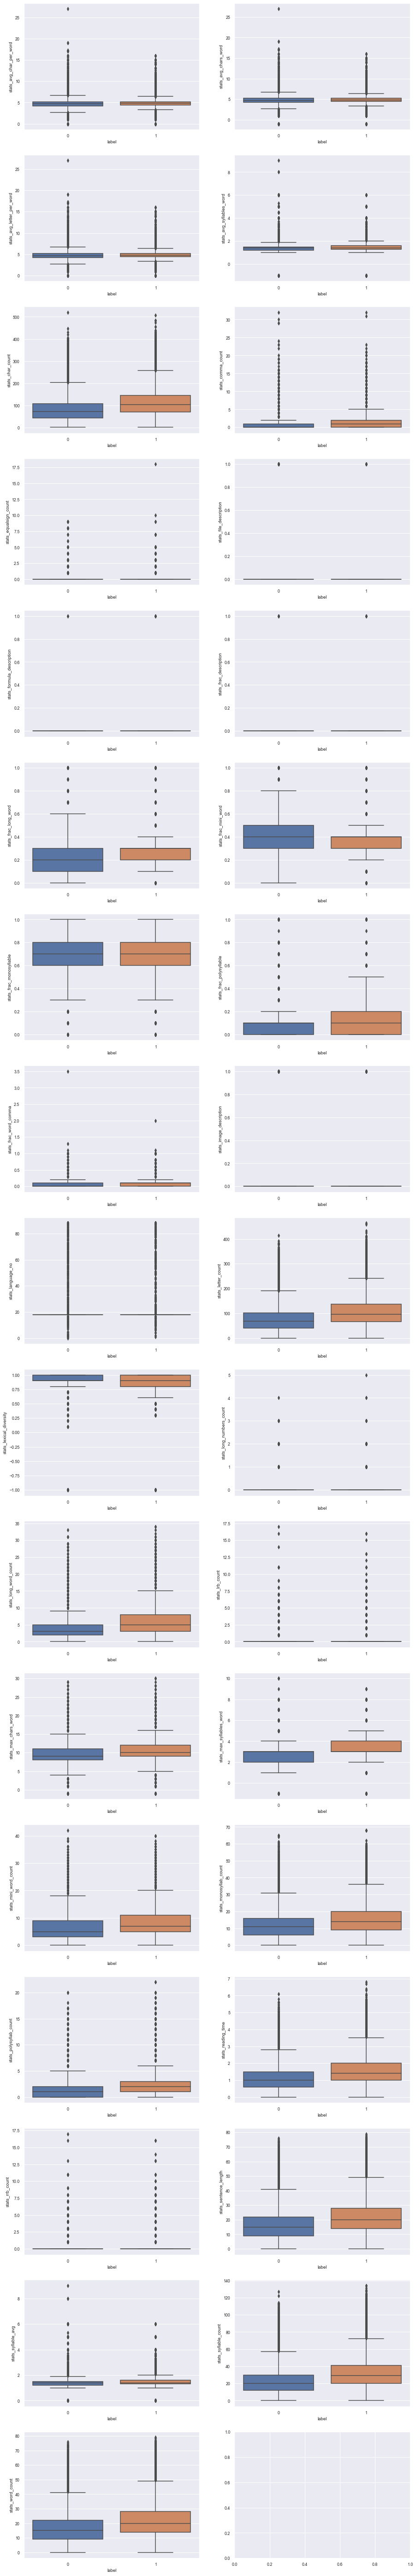

In [22]:
# Analyze stats_ feature group
feature_group = "stats_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

plot_boxplots(feature_group_train, df_train)

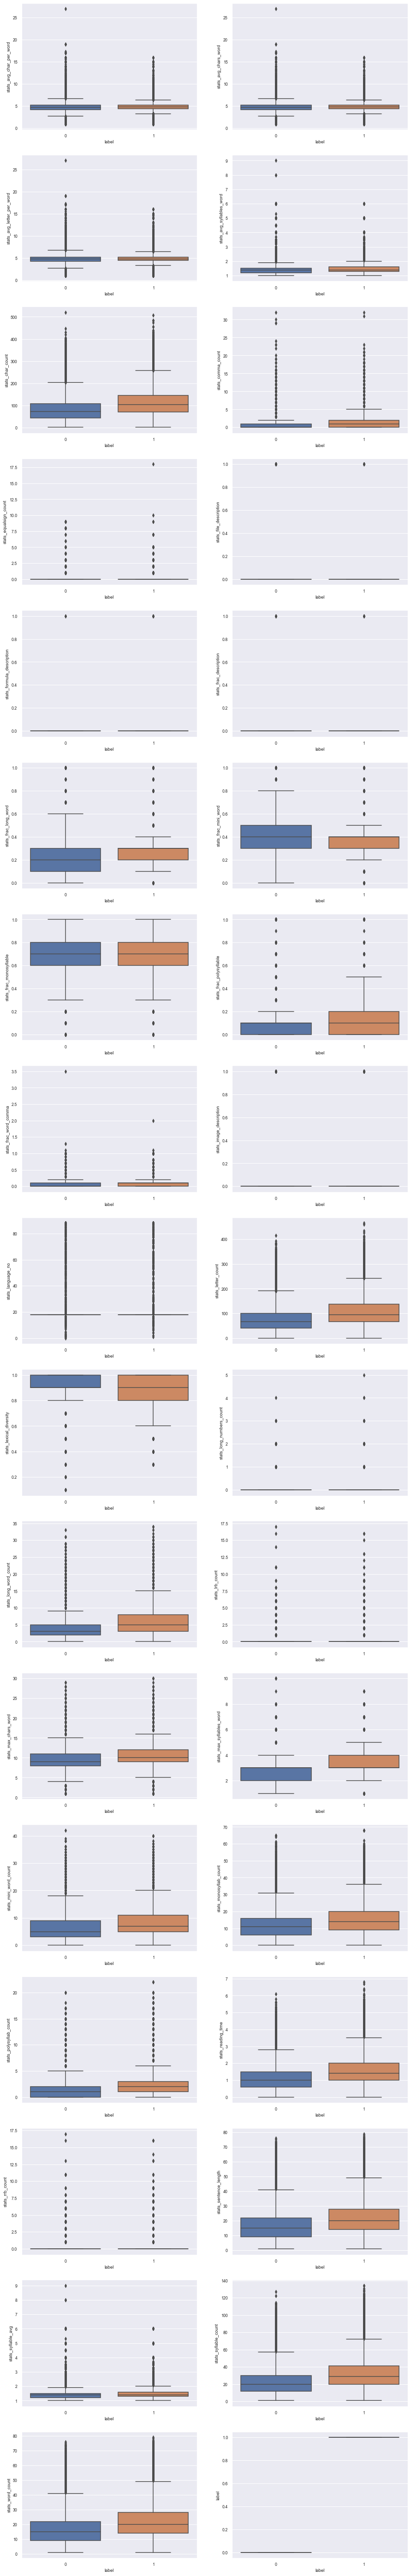

In [23]:
# Plot without missing values (-1)
feature_group_train.append('label')
df_plot = df_train[feature_group_train]
#df_plot = df_plot.replace(-1, df_plot.median())
df_plot = df_plot.replace(-1, np.nan)
df_plot = df_plot.dropna()
plot_boxplots(feature_group_train, df_plot)

### rs_

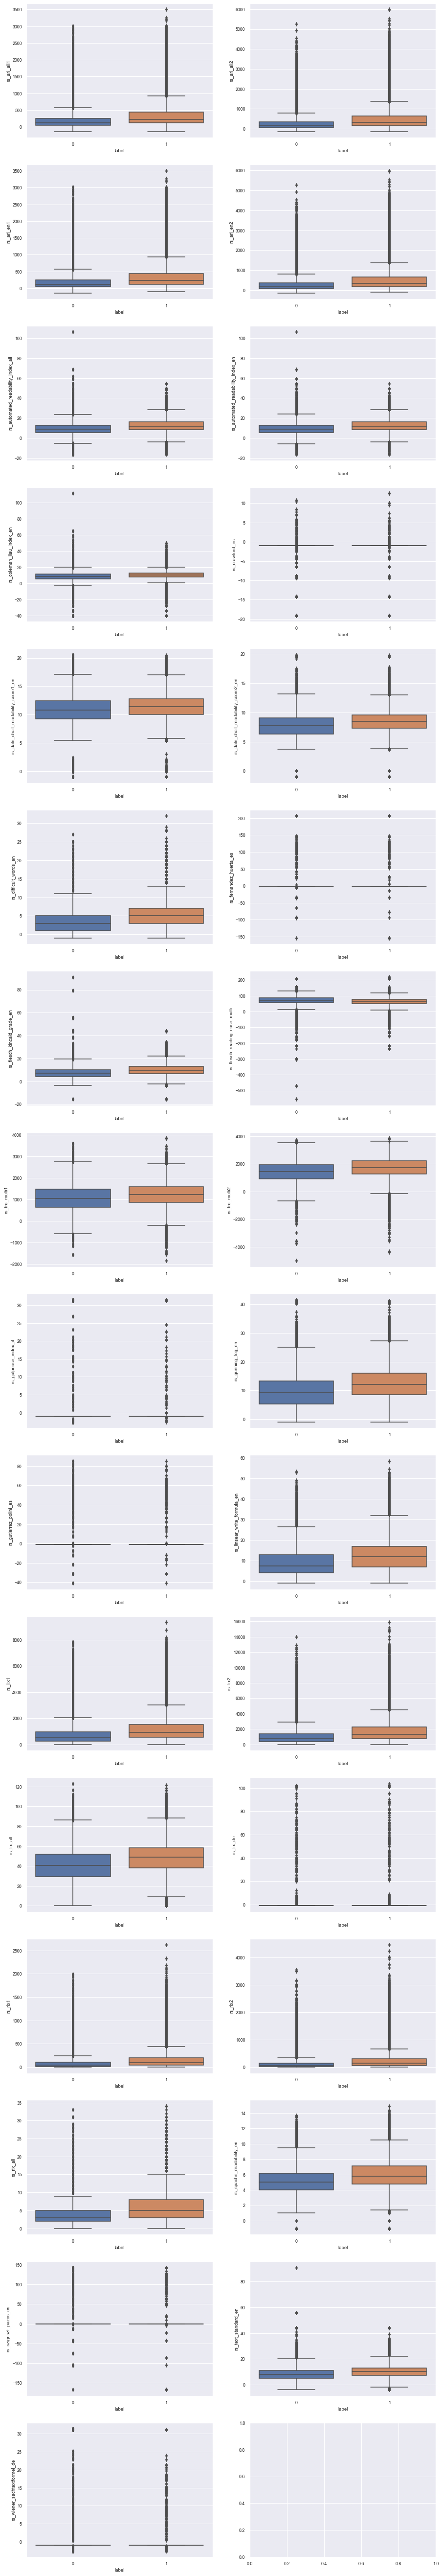

In [24]:
# Analyze stats_ feature group
feature_group = "rs_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

plot_boxplots(feature_group_train, df_train)

### nltk_

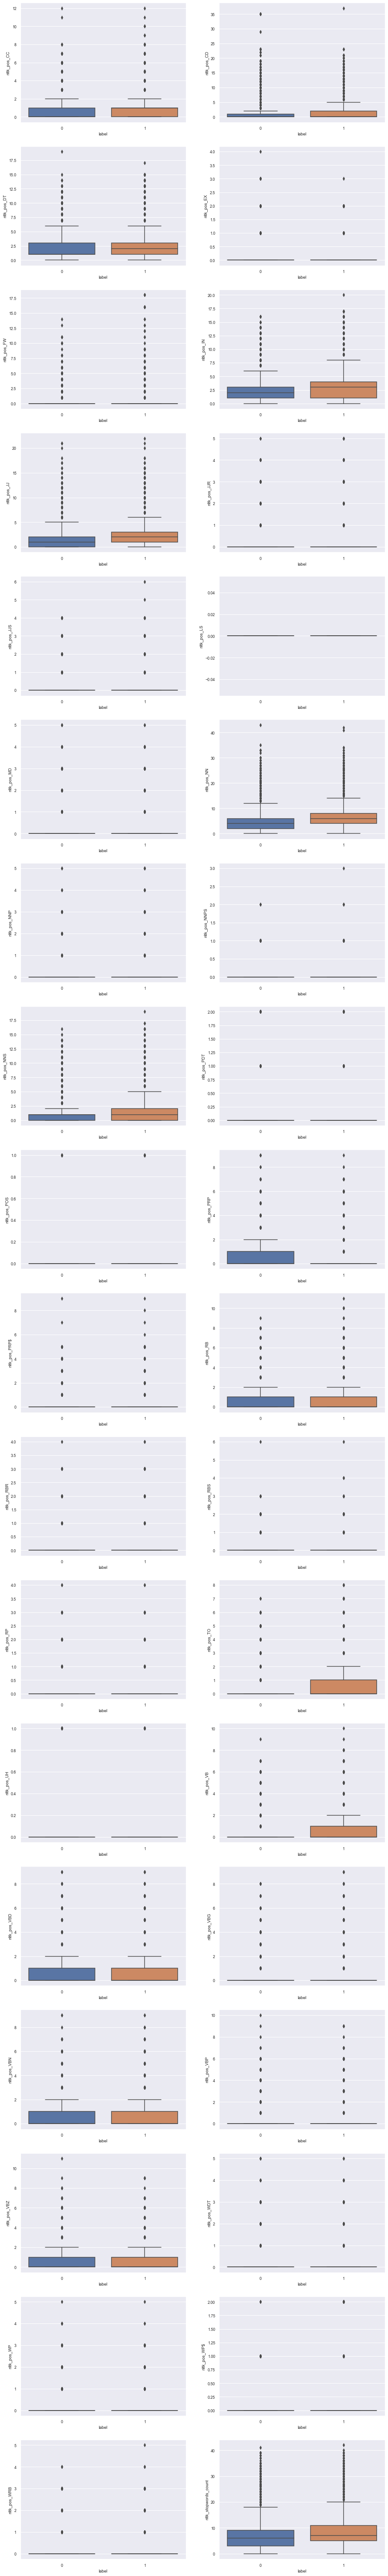

In [25]:
# Analyze stats_ feature group
feature_group = "nltk_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

plot_boxplots(feature_group_train, df_train)

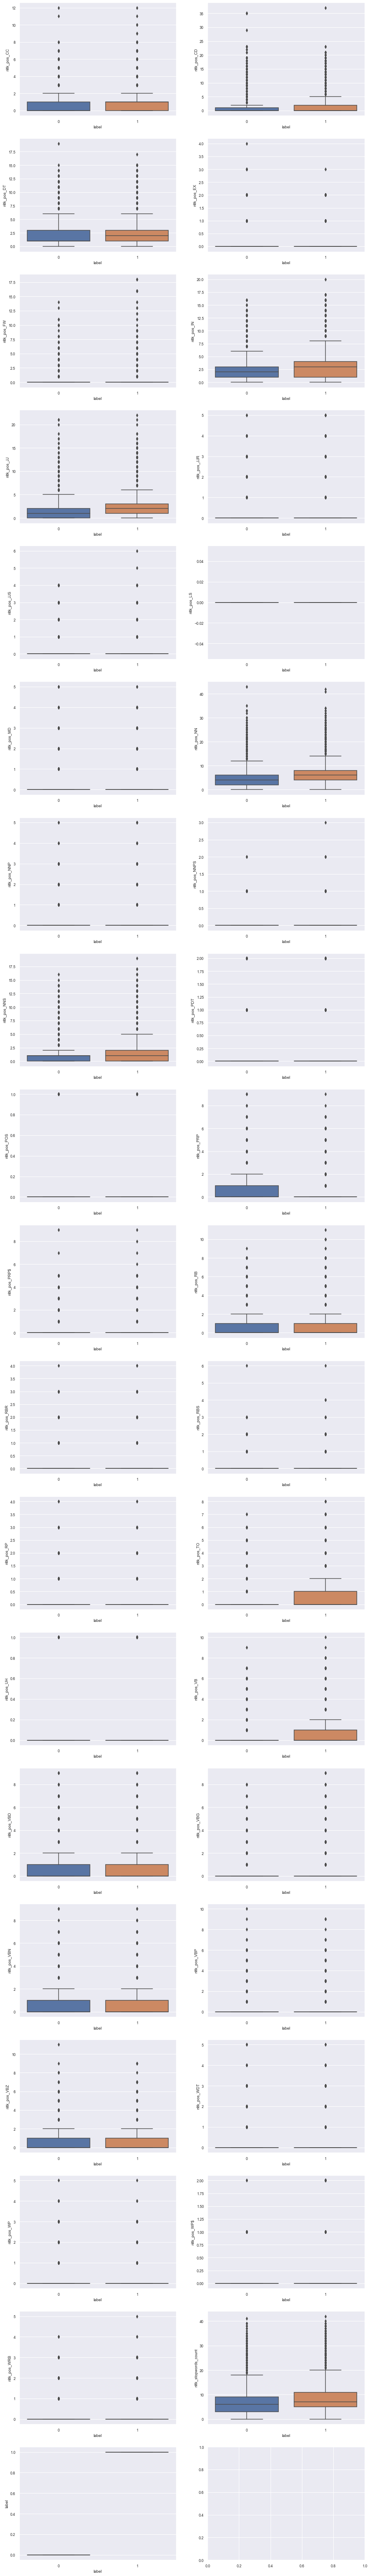

In [26]:
# Plot without missing values (-1)
feature_group_train.append('label')
df_plot = df_train[feature_group_train]
df_plot = df_plot.replace(-1, np.nan)
df_plot = df_plot.dropna()
plot_boxplots(feature_group_train, df_plot)

### aoa_

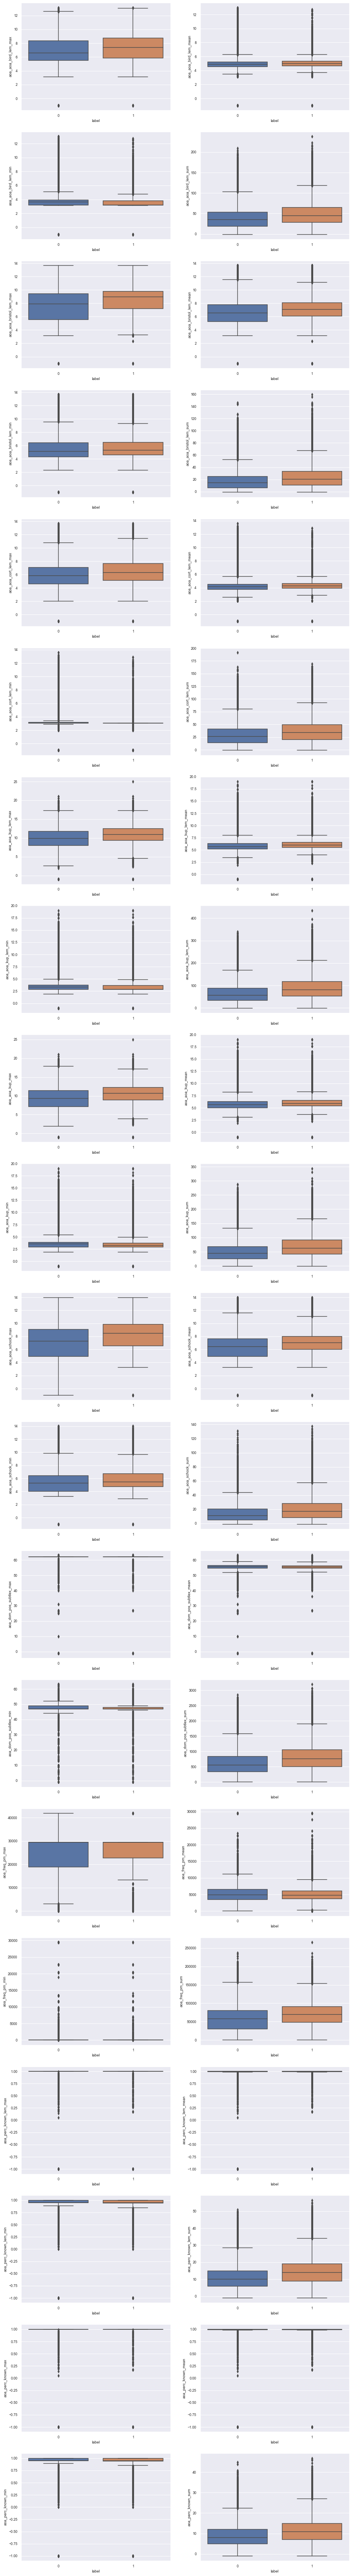

In [27]:
# Analyze stats_ feature group
feature_group = "aoa_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

plot_boxplots(feature_group_train, df_train)

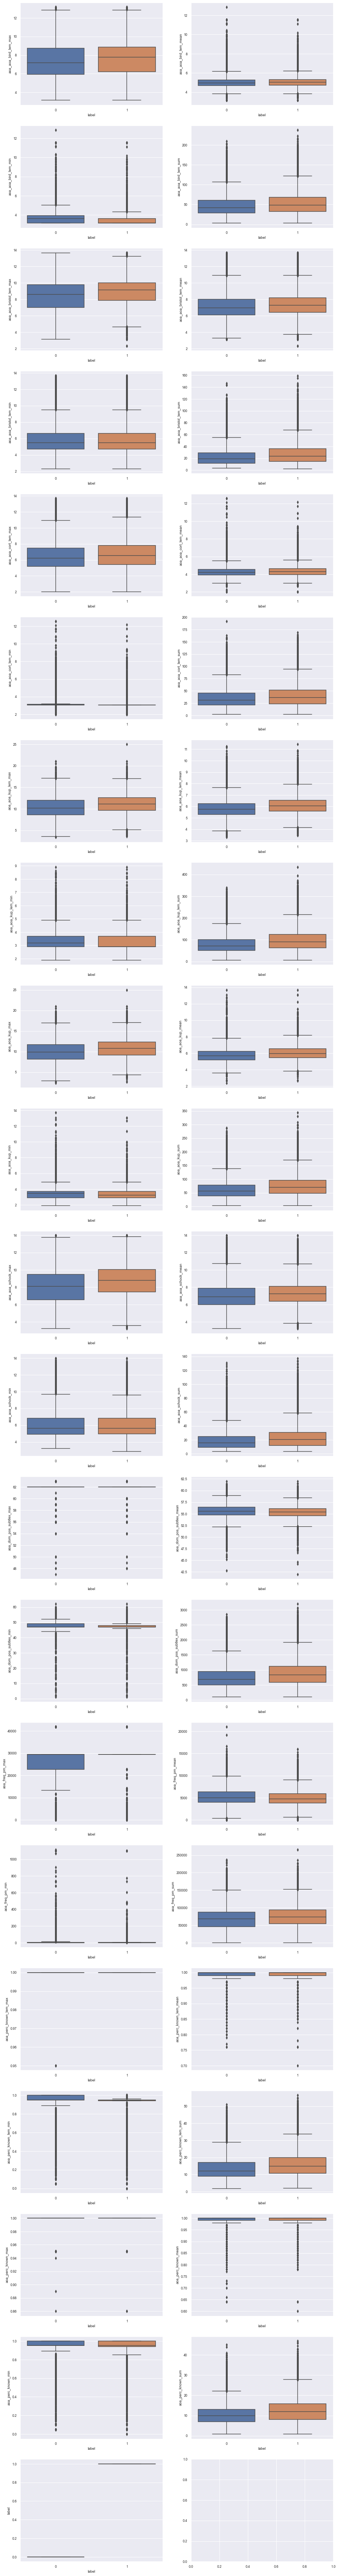

In [28]:
# Plot without missing values (-1)
feature_group_train.append('label')
df_plot = df_train[feature_group_train]
df_plot = df_plot.replace(-1, np.nan)
df_plot = df_plot.dropna()
plot_boxplots(feature_group_train, df_plot)

### crb_

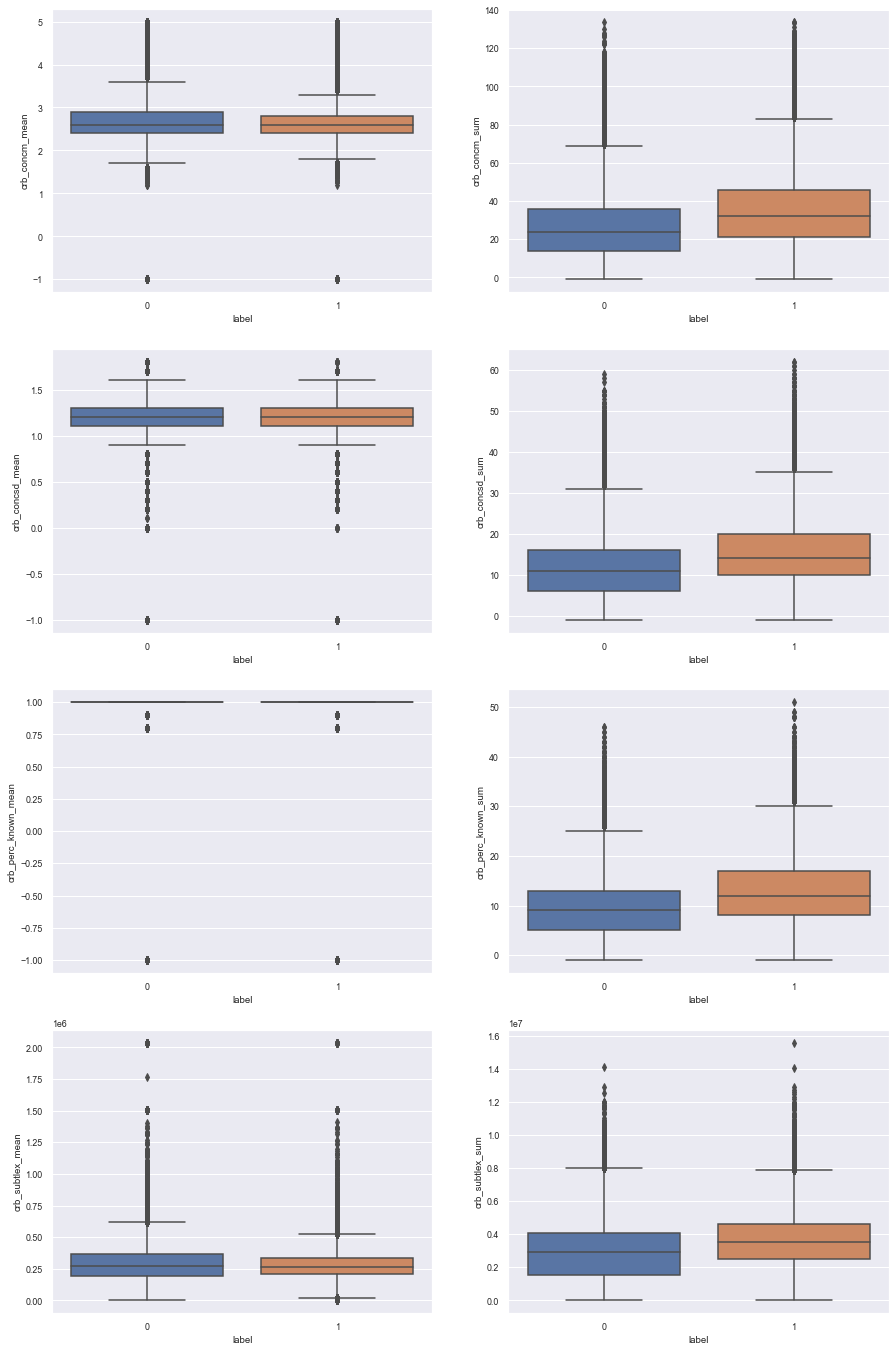

In [29]:
# Analyze stats_ feature group
feature_group = "crb_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

plot_boxplots(feature_group_train, df_train)

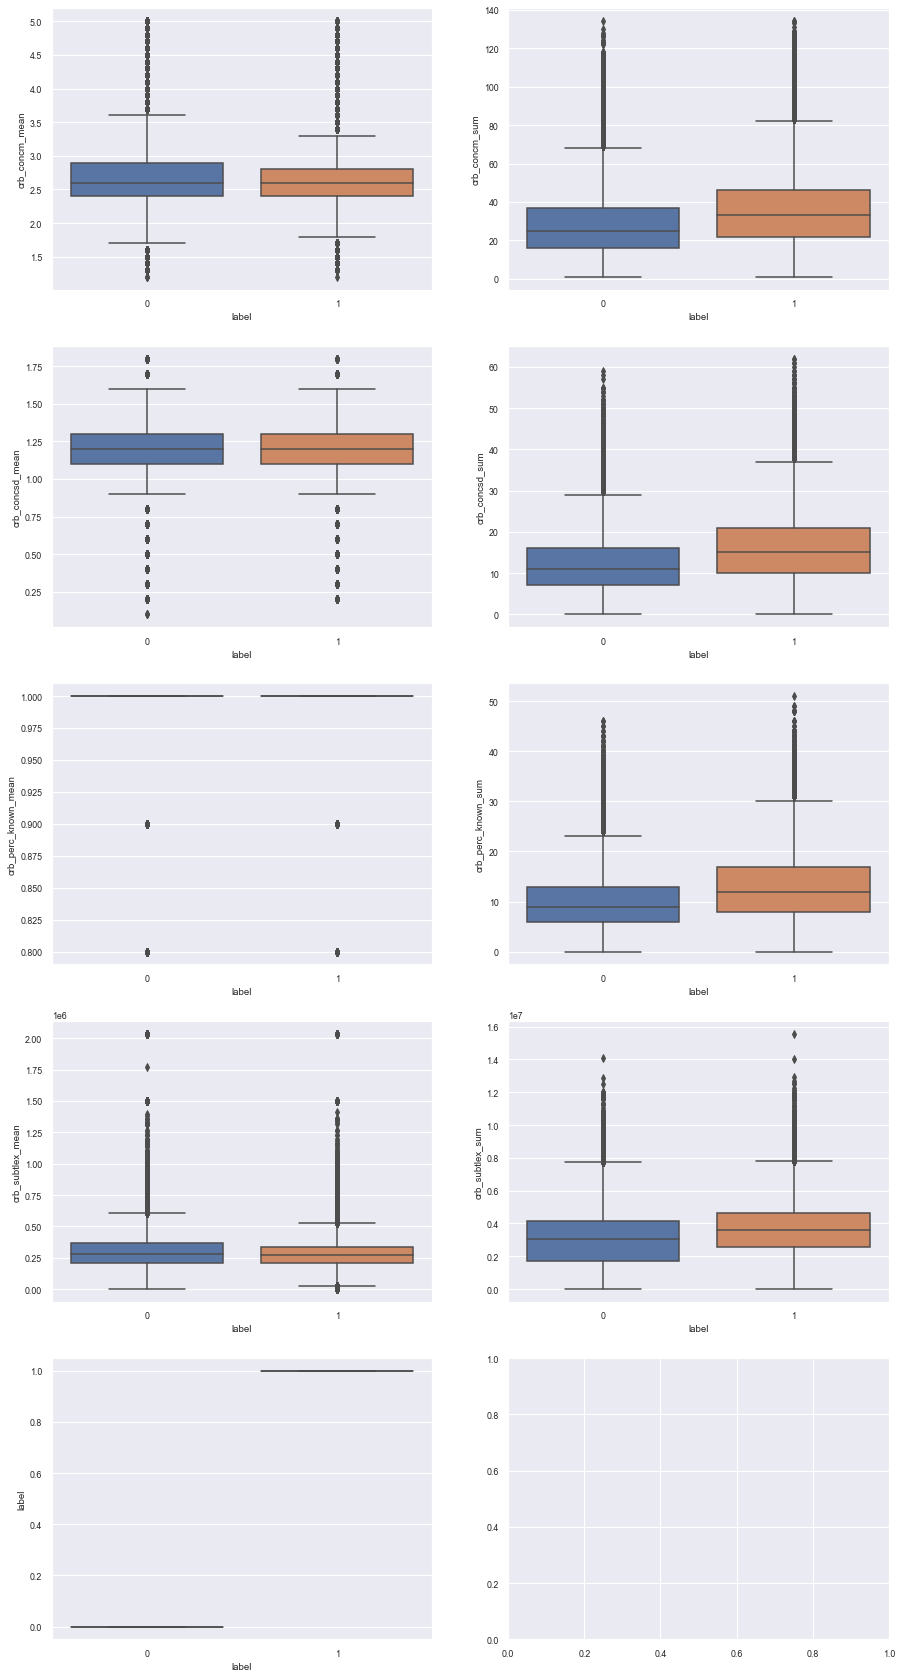

In [30]:
# Plot without missing values (-1)
feature_group_train.append('label')
df_plot = df_train[feature_group_train]
df_plot = df_plot.replace(-1, np.nan)
df_plot = df_plot.dropna()
plot_boxplots(feature_group_train, df_plot)

### w2v_

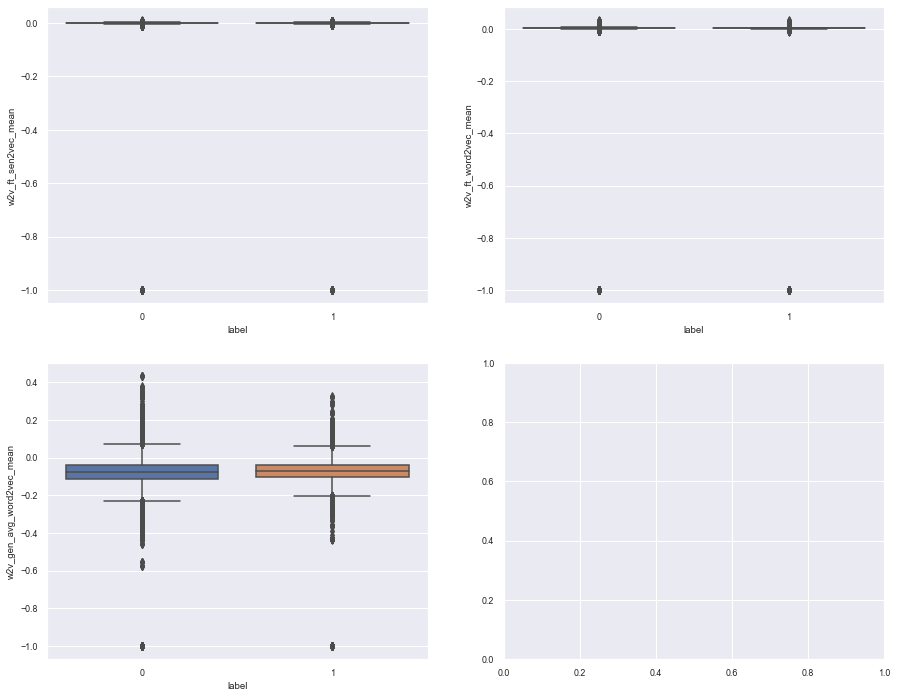

In [31]:
# Analyze stats_ feature group
feature_group = "w2v_"
feature_group_train = [feature for feature in columns_list_train if feature.startswith(feature_group)]

plot_boxplots(feature_group_train, df_train)

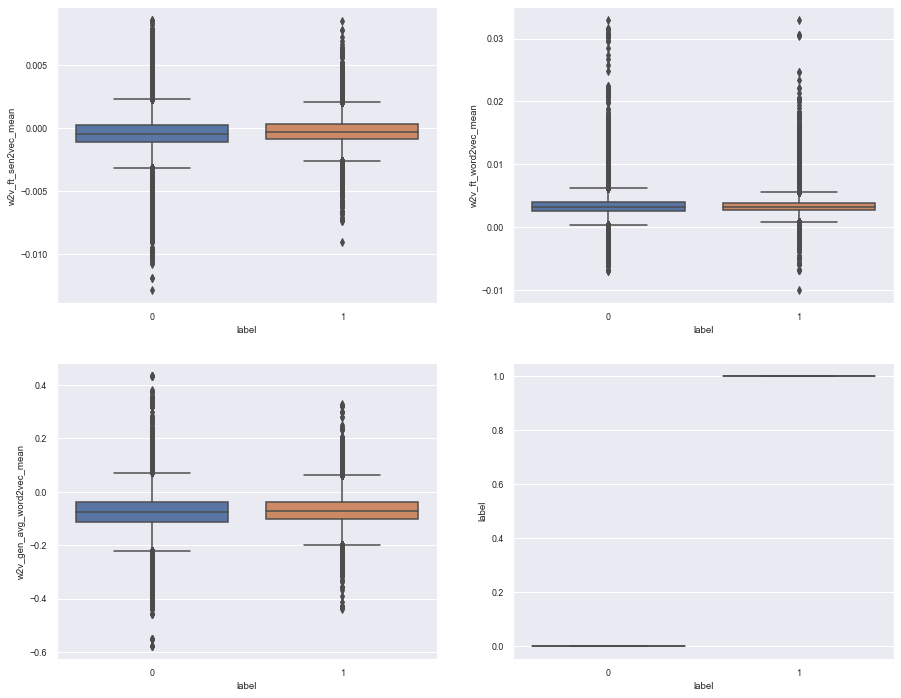

In [32]:
# Plot without missing values (-1)
feature_group_train.append('label')
df_plot = df_train[feature_group_train]
df_plot = df_plot.replace(-1, np.nan)
df_plot = df_plot.dropna()
plot_boxplots(feature_group_train, df_plot)

## Check Variance

In [56]:
# set the display format to show numbers as regular decimals
pd.options.display.float_format = '{:.4f}'.format

variance = df_train.var()
df_var = variance.to_frame().reset_index().rename(columns={0: 'variance', 'index':'feature'}).sort_values('variance', ascending=False)
df_var

,feature,variance
47,crb_subtlex_sum,3153500876983.3130
46,crb_subtlex_mean,19505378822.2315
31,aoa_freq_pm_sum,1186166645.9307
28,aoa_freq_pm_max,86394682.2015
29,aoa_freq_pm_mean,6424801.2142
106,rs_lix2,1658065.0475
105,rs_lix1,724340.5242
30,aoa_freq_pm_min,540662.5020
100,rs_fre_multi2,530927.0540
99,rs_fre_multi1,336079.5881


In [57]:
df_features_high_variance = df_var[df_var['variance'] > 0.25]
ic(len(df_features_high_variance));
df_features_high_variance.to_csv(ROOT_PATH + PATH_DATA_INT+"train_high_variance_features.csv")

ic| len(df_features_high_variance): 106


106

# Watermark

In [250]:
% watermark

UsageError: Line magic function `%` not found.


In [251]:
% watermark --iversions

UsageError: Line magic function `%` not found.


In [252]:
t_end = time.time()
total_runtime = t_end - t_start
total_runtime_min = round((total_runtime / 60), 2)
print(str(total_runtime_min) + " minutes")

5.38 minutes
